In [1]:
import pickle
import os
import torch
import numpy as np
import pandas as pd
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statistics import mean
import plotly.graph_objects as go
from scipy.interpolate import griddata
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import tqdm
# jupyter notebook display setting for all data structures
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
np.set_printoptions(threshold=np.inf)

## defining and executing the plotter

In [2]:
def plotter(raw_data, threshold, given_title):
    scaled_data = {}
    for key, value in raw_data.items():
        scaled_data[key] = value / 80000
    selected_data = []
    for value in scaled_data.values():
        selected_data.append(value[:,:,threshold])
    selected_data = np.array(selected_data)
    # flatten the first two dimensions
    data = selected_data.reshape(-1, 20)

    # extract percentiles from the data
    percentile_data = {}
    for i in range (3, 15):
        percentile_data[i] = {95: np.percentile(data[:, i], 95), 99: np.percentile(data[:, i], 99), 99.5: np.percentile(data[:, i], 99.5)}
    
    # use the percentiles to see if there are values above this threshold in the raw_data
    bubble_counts = {}
    for percentile in [95, 99, 99.5]:
        bubble_counts[percentile] = {}
        for i in range(3, 15):
            bubble_positive = 0
            bubble_negative = 0
            for value in scaled_data.values():  
                if np.max(value[:,i,threshold]) > percentile_data[i][percentile]:
                    bubble_positive += 1
                else:
                    bubble_negative += 1
            bubble_counts[percentile][i] = {'positive': bubble_positive, 'negative': bubble_negative}
            
    # plot the data
    fig, ax = plt.subplots(4, 3, figsize=(15, 15))
    # revel the axis
    ax = ax.ravel()
    for i in range(3, 15):
        # create histogram of the data
        ax[i-3].hist(data[:, i], bins=100, color='cyan', alpha=0.7)
        ax[i-3].set_title(f'Bubble Length = {i}')
        # set x limit at 99.999 percentile
        ax[i-3].set_xlim(0, np.percentile(data[:, i], 99.99))
        # use scientific notation for the x axis
        ax[i-3].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        # use a log scale for the y axis
        ax[i-3].set_yscale('log')
        # x-title is Probability, y-title is Frequency
        ax[i-3].set_xlabel('Probability')
        ax[i-3].set_ylabel('Frequency')
        # create a vertical line at the 95th, 99th and 99.5th percentile and annotate with the value, with the alignment of the text at the top
        ax[i-3].axvline(np.percentile(data[:, i], 95), color='red', linestyle='dashed')
        ax[i-3].axvline(np.percentile(data[:, i], 99), color='red', linestyle='dashed')
        ax[i-3].axvline(np.percentile(data[:, i], 99.5), color='red', linestyle='dashed')
        ax[i-3].text(np.percentile(data[:, i], 95), 100, '95th: {:.4f}'.format(np.percentile(data[:, i], 95)), rotation=90, ha='left', va='bottom')
        ax[i-3].text(np.percentile(data[:, i], 99), 100, '99th: {:.4f}'.format(np.percentile(data[:, i], 99)), rotation=90, ha='left', va='bottom')
        ax[i-3].text(np.percentile(data[:, i], 99.5), 100, '99.5th: {:.4f}'.format(np.percentile(data[:, i], 99.5)), rotation=90, ha='left', va='bottom')
        # set a super title
    plt.suptitle(f'{given_title}\n', fontsize=20)
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(3, 1, figsize=(10, 15))  # create a 3x1 grid of subplots

    color = ['lightgreen', 'lightblue', 'lightcoral']

    for n, percentile in zip([0,1,2],[95, 99, 99.5]):
        axs[n].bar(np.arange(3, 15), np.percentile(data[:,3:15], percentile, axis=0), color=color[n], alpha=0.7, label=f'{percentile}th Percentile')
        axs[n].set_xlabel('Bubble Length')
        axs[n].set_ylabel('Probability')
        axs[n].set_xticks(np.arange(3, 15))
        # display the value of the bar on top of the bar with a rotation of 90 degrees
        for i, v in enumerate(np.percentile(data[:,3:15], percentile, axis=0)):
            axs[n].text(i+2.6, v+0.00001, '{:.4f}'.format(v))
        for i, v in enumerate(np.percentile(data[:,3:15], percentile, axis=0)):
            axs[n].text(i+2.6, v-((percentile_data[3][percentile])/20), f'{(bubble_counts[percentile][i+3]["positive"]/(bubble_counts[percentile][i+3]["positive"]+bubble_counts[percentile][i+3]["negative"]))*100: .1f}%')
        # add text in legend explaining that the percentage is the number of positive bubbles over the number of negative bubbles, align left
        axs[n].legend(title='% = Bubble Positive using this threshold')

        axs[n].set_title(f'{percentile}th Percentile of Bubble Lengths')

    # set a super title
    plt.suptitle(f'{given_title}\n', fontsize=20)
    plt.tight_layout()
    plt.show()

## bringing in chipseq data

In [2]:
# define data file
data_file = '/project2/xinhe/waqaas/DNA-breathing/data/chipseq_features/bubble_data/bubble_data_overall.pkl'

In [3]:
# load the file
with open(data_file, 'rb') as f:
    data = pickle.load(f)

In [4]:
# check out one of the data points
for key, value in data.items():
    print(key)
    print(value.shape)
    break

2345200
(200, 20, 20)


In [40]:
plotter(data, 6)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

## bringing in gcPBM data

In [8]:
# data folder for the gcPBM data
data_folder = '/project2/xinhe/waqaas/DNA-breathing/data/gcPBM_features/bubble_data/mad_gcPBM_flanks'

In [4]:
# compile the pkls into a single dictionary
gcPBM_data = {}
for file in os.listdir(data_folder):
    with open(os.path.join(data_folder, file), 'rb') as f:
        data = pickle.load(f)
        gcPBM_data[file.split('.')[0]] = data['bubbles']

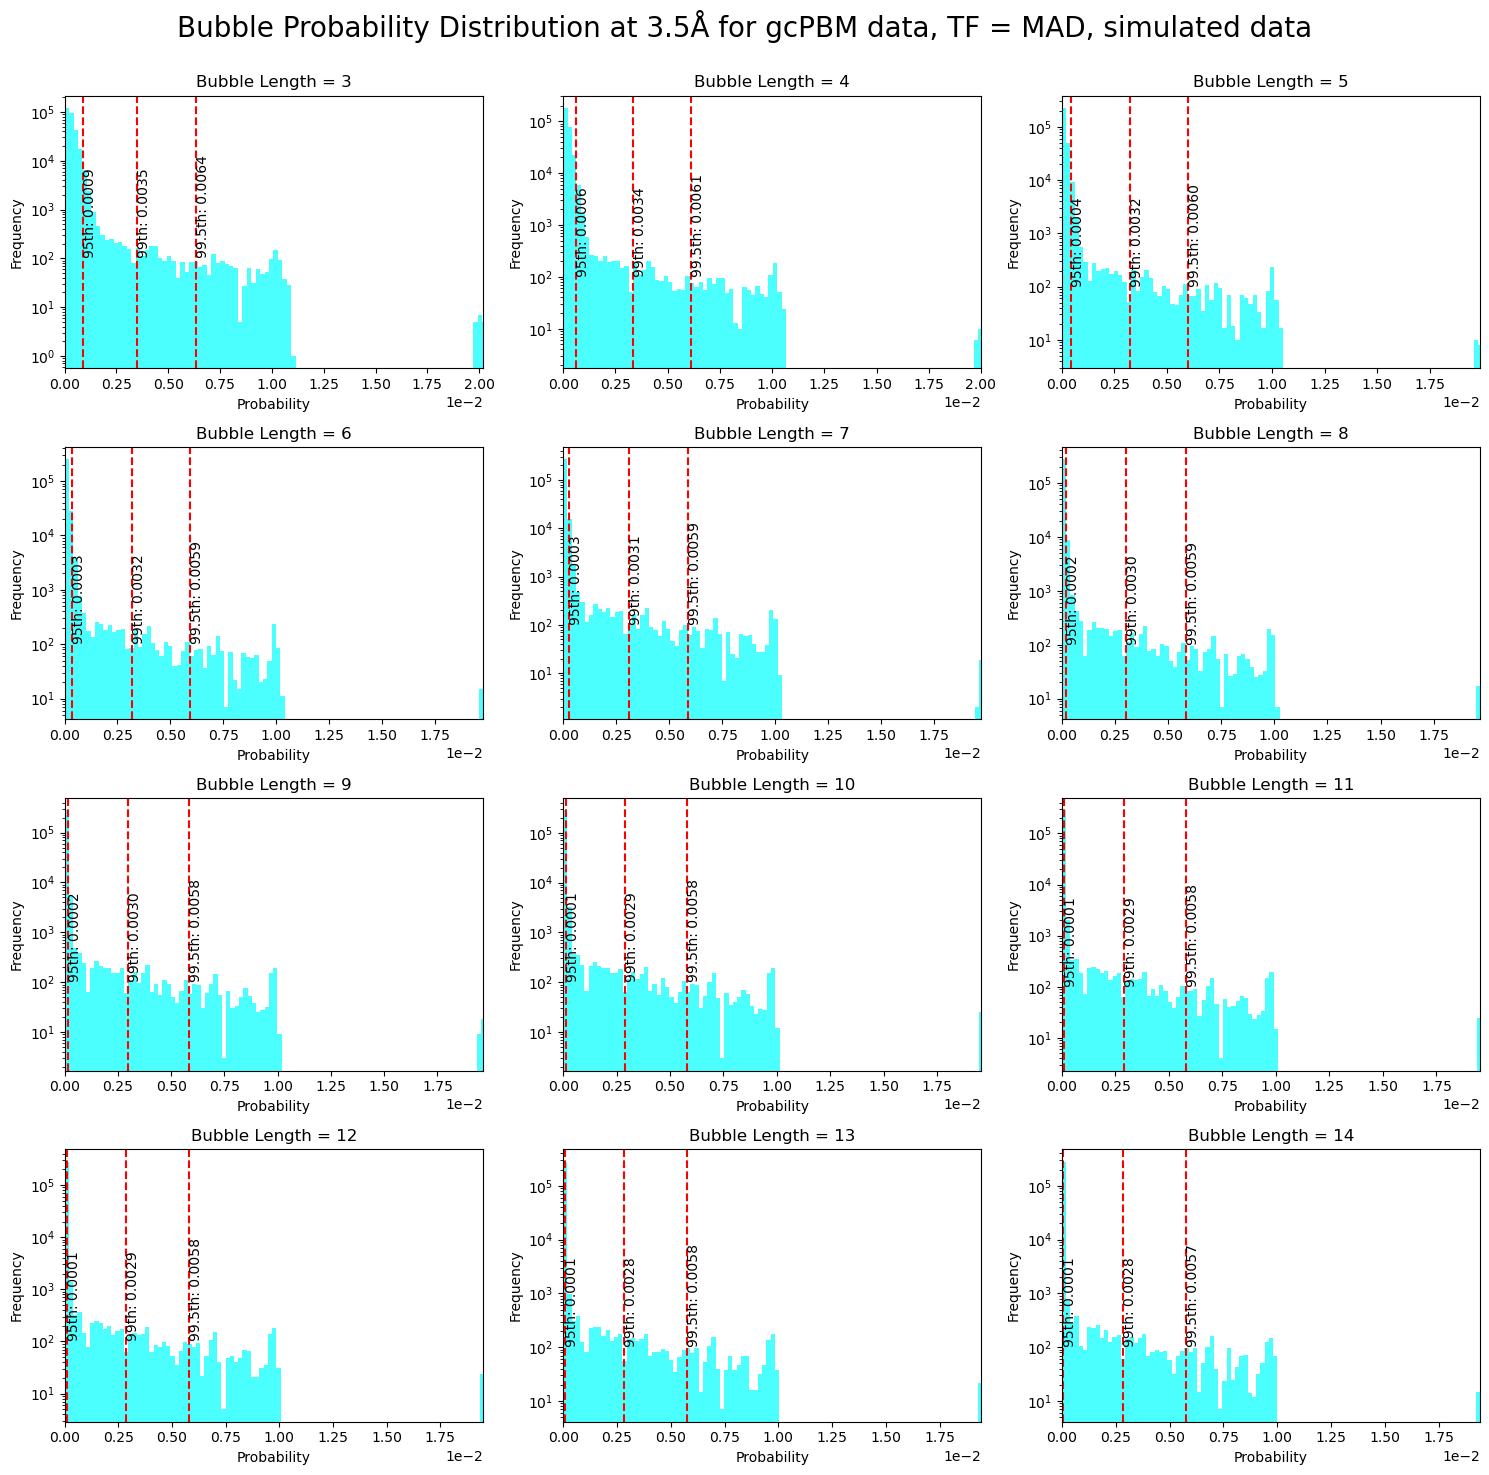

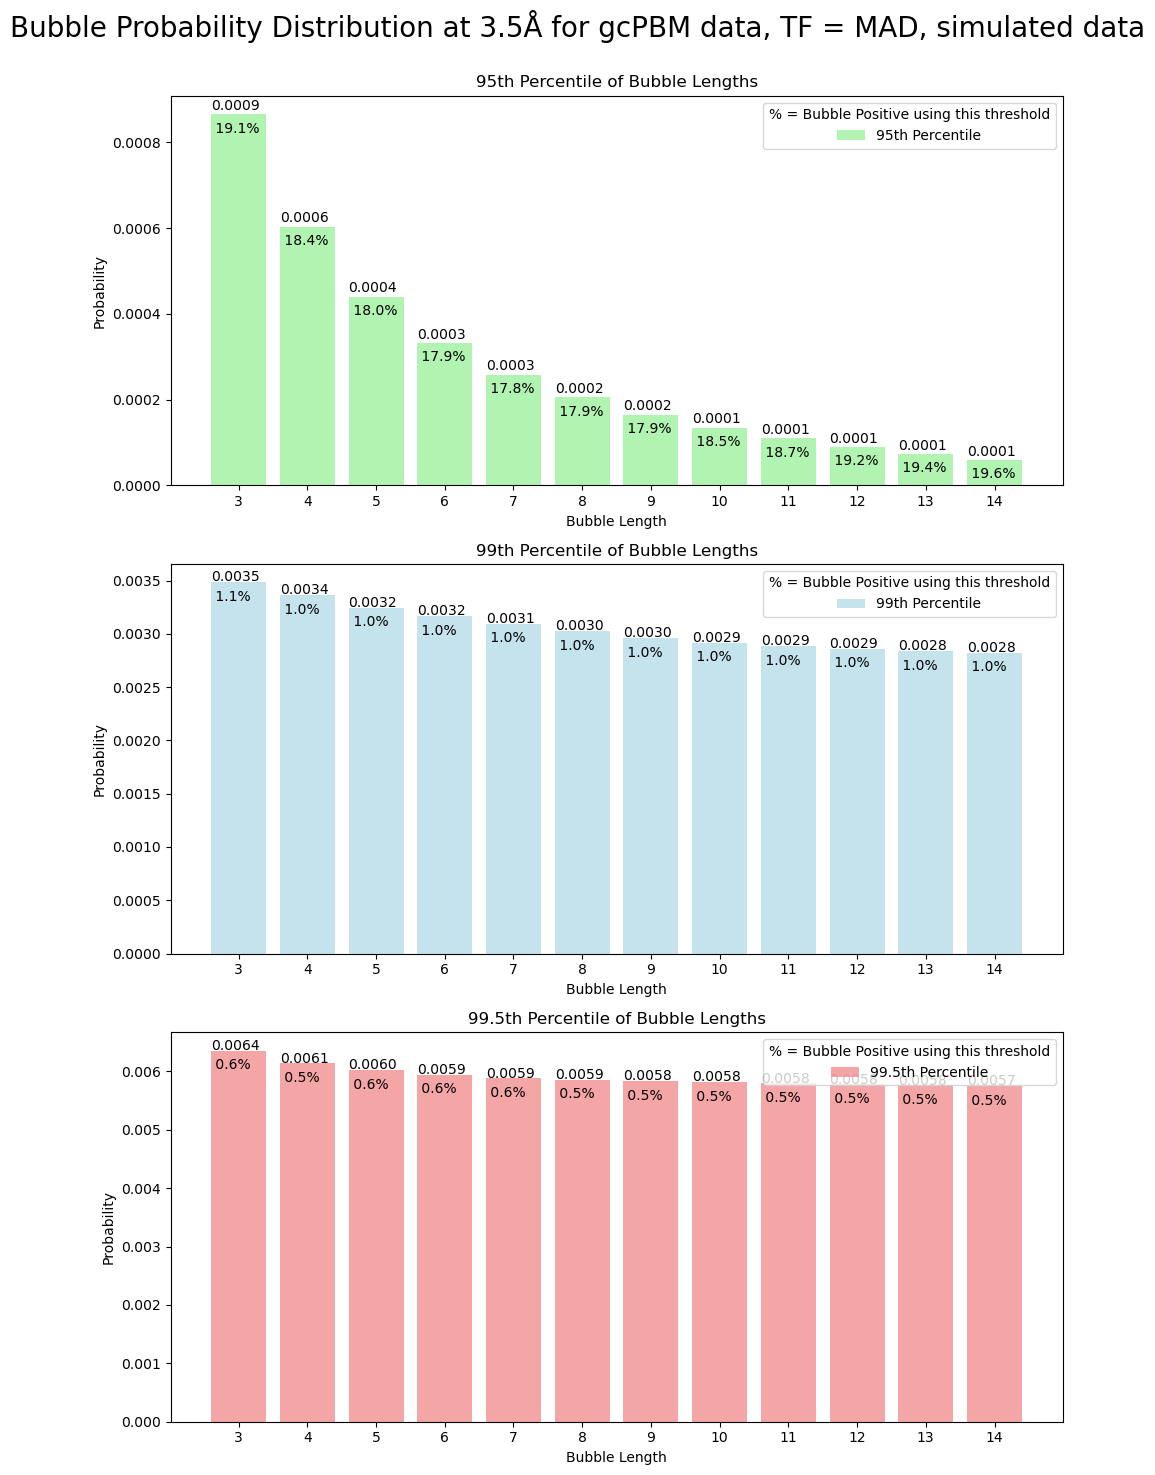

In [5]:
plotter(gcPBM_data, 6, 'Bubble Probability Distribution at 3.5Å for gcPBM data, TF = MAD, simulated data')

## using the old bubble data

In [6]:
# load the mad data
with open('/project2/xinhe/waqaas/DNA-breathing/data/gcPBM_data/mad.pkl', 'rb') as f:
    mad_data = pickle.load(f)

In [7]:
mad = {}
for part in mad_data.keys():
    partition = mad_data[part]
    for key in partition.keys():
        mad[key] = partition[key]

In [16]:
# only keep the keys in mad that are also in gcPBM_data
mad = {key: value['bubble'] for key, value in mad.items() if str(key) in gcPBM_data.keys()}

In [21]:
mad_reshaped = {}
for key, value in mad.items():
    # split the 130, 36 matrix into 13, 10, 36
    value = value.reshape(13, 10, 36)
    # the dimensions should be changed from 13, 10, 36 to 36, 10, 13
    value = value.transpose(2, 1, 0)
    mad_reshaped[key] = value

In [28]:
# def a variant of the plotter
def plotter_for_old_data(raw_data, threshold, given_title):
    selected_data = []
    for value in raw_data.values():
        selected_data.append(value[:,:,threshold])
    selected_data = np.array(selected_data)
    # flatten the first two dimensions
    data = selected_data.reshape(-1, 10)

    # extract percentiles from the data
    percentile_data = {}
    for i in range(len(data[1])):
        percentile_data[i] = {95: np.percentile(data[:, i], 95), 99: np.percentile(data[:, i], 99), 99.5: np.percentile(data[:, i], 99.5)}
    
    # use the percentiles to see if there are values above this threshold in the raw_data
    bubble_counts = {}
    for percentile in [95, 99, 99.5]:
        bubble_counts[percentile] = {}
        for i in range(len(data[1])):
            bubble_positive = 0
            bubble_negative = 0
            for value in raw_data.values():  
                if np.max(value[:,i,threshold]) > percentile_data[i][percentile]:
                    bubble_positive += 1
                else:
                    bubble_negative += 1
            bubble_counts[percentile][i] = {'positive': bubble_positive, 'negative': bubble_negative}
            
    # plot the data
    fig, ax = plt.subplots(4, 3, figsize=(15, 15))
    # revel the axis
    ax = ax.ravel()
    for i in range(len(data[1])):
        # create histogram of the data
        ax[i].hist(data[:, i], bins=100, color='cyan', alpha=0.7)
        ax[i].set_title(f'Bubble Length = {i+3}')
        # set x limit at 99.999 percentile
        ax[i].set_xlim(0, np.percentile(data[:, i], 99.99))
        # use scientific notation for the x axis
        ax[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        # use a log scale for the y axis
        ax[i].set_yscale('log')
        # x-title is Probability, y-title is Frequency
        ax[i].set_xlabel('Probability')
        ax[i].set_ylabel('Frequency')
        # create a vertical line at the 95th, 99th and 99.5th percentile and annotate with the value, with the alignment of the text at the top
        ax[i].axvline(np.percentile(data[:, i], 95), color='red', linestyle='dashed')
        ax[i].axvline(np.percentile(data[:, i], 99), color='red', linestyle='dashed')
        ax[i].axvline(np.percentile(data[:, i], 99.5), color='red', linestyle='dashed')
        ax[i].text(np.percentile(data[:, i], 95), 100, '95th: {:.4f}'.format(np.percentile(data[:, i], 95)), rotation=90, ha='left', va='bottom')
        ax[i].text(np.percentile(data[:, i], 99), 100, '99th: {:.4f}'.format(np.percentile(data[:, i], 99)), rotation=90, ha='left', va='bottom')
        ax[i].text(np.percentile(data[:, i], 99.5), 100, '99.5th: {:.4f}'.format(np.percentile(data[:, i], 99.5)), rotation=90, ha='left', va='bottom')
        # set a super title
    plt.suptitle(f'{given_title}\n', fontsize=20)
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(3, 1, figsize=(10, 15))  # create a 3x1 grid of subplots

    color = ['lightgreen', 'lightblue', 'lightcoral']

    for n, percentile in zip([0,1,2],[95, 99, 99.5]):
        axs[n].bar(np.arange(3, 13), np.percentile(data[:,:], percentile, axis=0), color=color[n], alpha=0.7, label=f'{percentile}th Percentile')
        axs[n].set_xlabel('Bubble Length')
        axs[n].set_ylabel('Probability')
        axs[n].set_xticks(np.arange(3, 13))
        # display the value of the bar on top of the bar with a rotation of 90 degrees
        for i, v in enumerate(np.percentile(data[:,:], percentile, axis=0)):
            axs[n].text(i+2.6, v+0.00001, '{:.4f}'.format(v))
        for i, v in enumerate(np.percentile(data[:,:], percentile, axis=0)):
            axs[n].text(i+2.6, v-((percentile_data[0][percentile])/20), f'{(bubble_counts[percentile][i]["positive"]/(bubble_counts[percentile][i]["positive"]+bubble_counts[percentile][i]["negative"]))*100: .1f}%')
        # add text in legend explaining that the percentage is the number of positive bubbles over the number of negative bubbles, align left
        axs[n].legend(title='% = Bubble Positive using this threshold')

        axs[n].set_title(f'{percentile}th Percentile of Bubble Lengths')
    # set the super title
    plt.suptitle(f'{given_title}\n', fontsize=20)
    plt.tight_layout()
    plt.show()

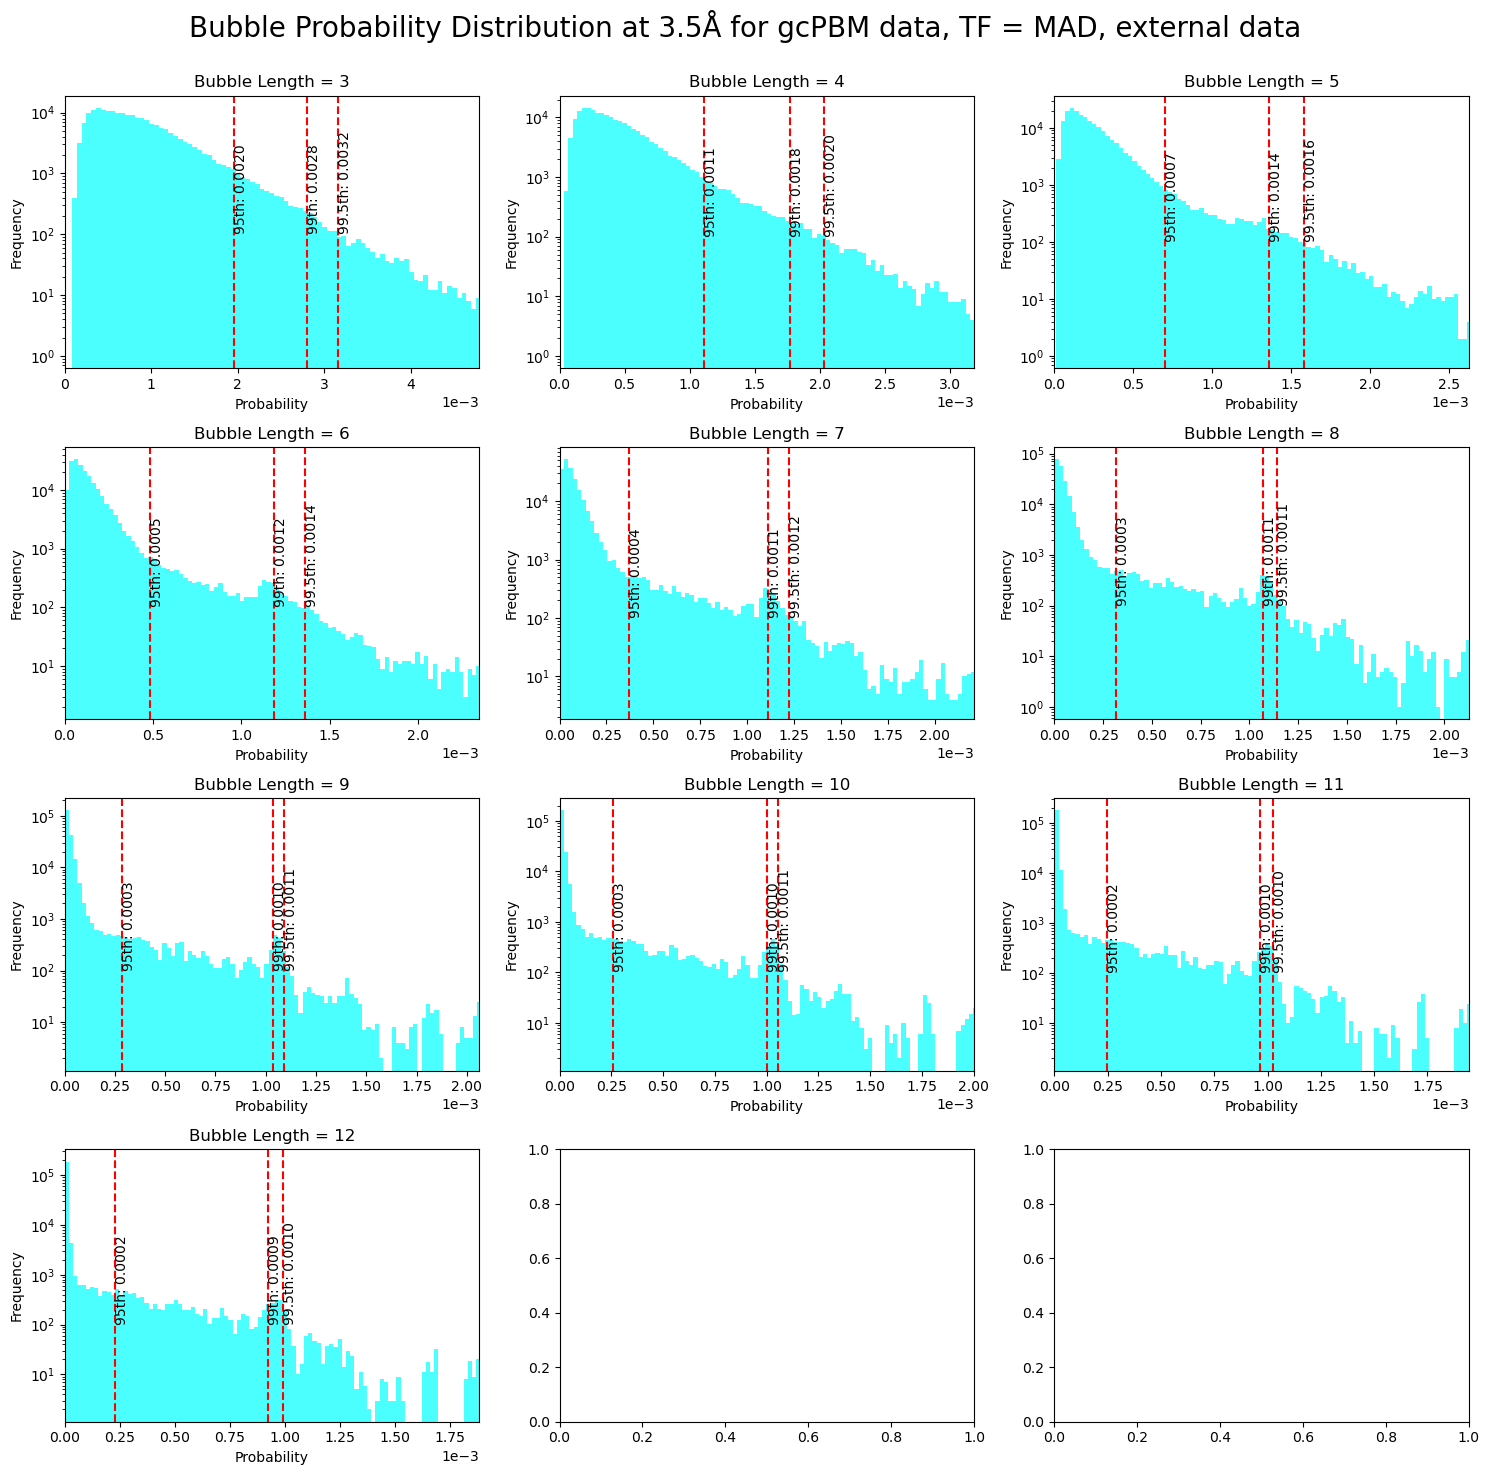

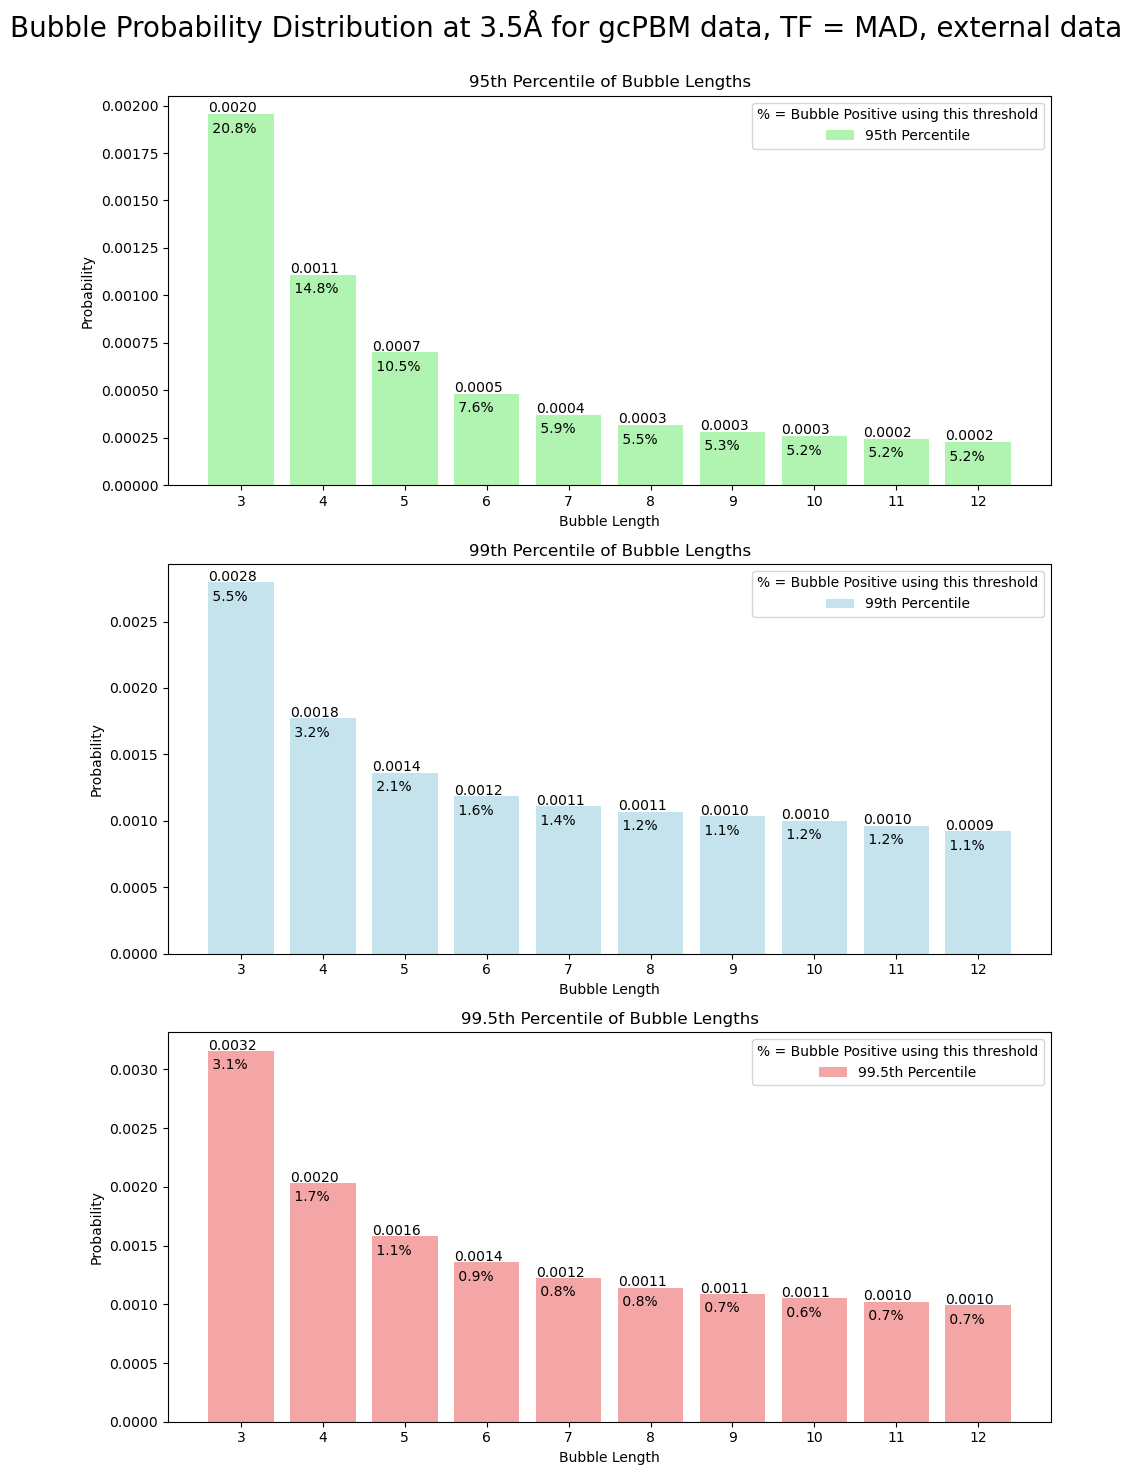

In [29]:
plotter_for_old_data(mad_reshaped, 6, 'Bubble Probability Distribution at 3.5Å for gcPBM data, TF = MAD, external data')

## running correlations with binding affinity

In [10]:
# load the mad data
with open('/project2/xinhe/waqaas/DNA-breathing/data/gcPBM_data/mad.pkl', 'rb') as f:
    mad_data = pickle.load(f)

mad = {}
for part in mad_data.keys():
    partition = mad_data[part]
    for key in partition.keys():
        mad[key] = partition[key]

In [29]:
# give the label from mad to the gcPBM data
mad_composite = {}
for key, value in gcPBM_data.items():
    mad_composite[int(key)] = {}
    mad_composite[int(key)]['bubble'] = gcPBM_data[key]
    mad_composite[int(key)]['label'] = mad[int(key)]['label']

In [33]:
mad_composite[4481]

{'bubble': array([[[0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
         [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
         [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
         [1.16225e+03, 4.22090e+02, 1.67500e+02, 7.20000e

mad sequencing is still incomplete, revisit

In [36]:
def data_prep(raw_data, threshold):
    scaled_data = {}
    for key, value in raw_data.items():
        scaled_data[key] = {}
        scaled_data[key]['bubble'] = value['bubble'] / 80000
        scaled_data[key]['label'] = value['label']
    selected_data = []
    for value in scaled_data.values():
        selected_data.append(value['bubble'][:,:,threshold])
    selected_data = np.array(selected_data)
    # flatten the first two dimensions
    data = selected_data.reshape(-1, 20)

    # extract percentiles from the data
    percentile_data = {}
    for i in range (3, 15):
        percentile_data[i] = {95: np.percentile(data[:, i], 95), 99: np.percentile(data[:, i], 99), 99.5: np.percentile(data[:, i], 99.5)}
    
    # use the percentiles to see if there are values above this threshold in the raw_data
    bubble_binary = {}
    for percentile in [95, 99, 99.5]:
        bubble_binary[percentile] = {}
        for i in range(3, 15):
            bubble_binary[percentile][i] = {}
            for key, value in scaled_data.items():  
                if np.max(value['bubble'][:,i,threshold]) > percentile_data[i][percentile]:
                    bubble_binary[percentile][i][key] = 1
                else:
                    bubble_binary[percentile][i][key] = 0

    correlation_data = {}
    for percentile in [95, 99, 99.5]:
        correlation_data[percentile] = {}
        for i in range(3, 15):
            correlation_data[percentile][i] = {}
            binary_values = []
            continuous_values = []
            for key in bubble_binary[percentile][i].keys():
                # Get the binary values from bubble_binary
                binary_values.append(bubble_binary[percentile][i][key])
                # Get the corresponding continuous values (labels) from scaled_data
                continuous_values.append(scaled_data[key]['label'])
            # Calculate the correlation between binary_values and continuous_values
            corr, p_value = stats.pointbiserialr(binary_values, continuous_values)
            # Store the correlation in correlation_data
            correlation_data[percentile][i] = (corr, p_value)

    return correlation_data, bubble_binary, percentile_data

In [37]:
# run the data_prep function
correlation_data, bubble_binary, percentile_data = data_prep(mad_composite, 6)

In [64]:
def correlation_plotter(correlation_data, percentiles, given_title):

    fig, axs = plt.subplots(len(percentiles), 2, figsize=(20, len(percentiles)*5))  # create a nx2 grid of subplots

    color = ['lightgreen', 'lightblue', 'lightcoral']

    for n, percentile in enumerate(percentiles):
        corr_data = []
        p_value = []
        log_p_value = []
        for i in range(3, 15):
            corr_data.append(correlation_data[percentile][i][0])
            # -log10 transform the p-value
            p = -np.log10(correlation_data[percentile][i][1])
            p_value.append(correlation_data[percentile][i][1])
            log_p_value.append(p)
        axs[n,0].bar(np.arange(3, 15), corr_data, color=color[n], alpha=0.7, label=f'Correlation at {percentile}th Percentile')
        axs[n,0].set_xlabel('Bubble Length')
        axs[n,0].set_ylabel('Correlation Coefficient (point biserial)')
        axs[n,0].set_xticks(np.arange(3, 15))
        # display the value of the bar on top of the bar
        for i, v in enumerate(corr_data):
            axs[n,0].text(i+2.6, v-(max(corr_data)/30), '{:.4f}'.format(v))

        axs[n,1].bar(np.arange(3, 15), log_p_value, color=color[n], alpha=0.7, label=f'P-value at {percentile}th Percentile')
        axs[n,1].set_xlabel('Bubble Length')
        axs[n,1].set_ylabel('-log10 p-value')
        axs[n,1].set_xticks(np.arange(3, 15))
        # display the value of the bar on top of the bar
        for i, v in enumerate(log_p_value):
            axs[n,1].text(i+2.6, v-(max(log_p_value)/30), '{:.4f}'.format(p_value[i]))

    # set a super title
    plt.suptitle(f'{given_title}\n', fontsize=20)
    plt.tight_layout()
    plt.show()

In [65]:
# run the correlation_plotter
correlation_plotter(correlation_data, [95, 99, 99.5], 'Correlation between Bubble Length and Label at 3.5Å for gcPBM data, TF = MAD')